#  <font color='red'>Global Path Planner</font> 

In [4]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix
import random
import time

#import seaborn as sns

# Dataset Preprocessing
# -------------------------------------------------------------------------------------------------------------

## Synthetic Dataset Initiation

In [5]:


def generate_points_with_min_distance(n, shape, min_dist):
    # compute grid shape based on number of points
    width_ratio = shape[1] / shape[0]
    num_y = np.int32(np.sqrt(n / width_ratio)) + 1
    num_x = np.int32(n / num_y) + 1

    # create regularly spaced neurons
    x = np.linspace(0., shape[1]-1, num_x, dtype=np.float32)
    y = np.linspace(0., shape[0]-1, num_y, dtype=np.float32)
    coords = np.stack(np.meshgrid(x, y), -1).reshape(-1,2)

    # compute spacing
    init_dist = np.min((x[1]-x[0], y[1]-y[0]))

    # perturb points
    max_movement = (init_dist - min_dist)/2
    noise = np.random.uniform(low=-max_movement,
                                high=max_movement,
                                size=(len(coords), 2))
    coords += noise

    return coords



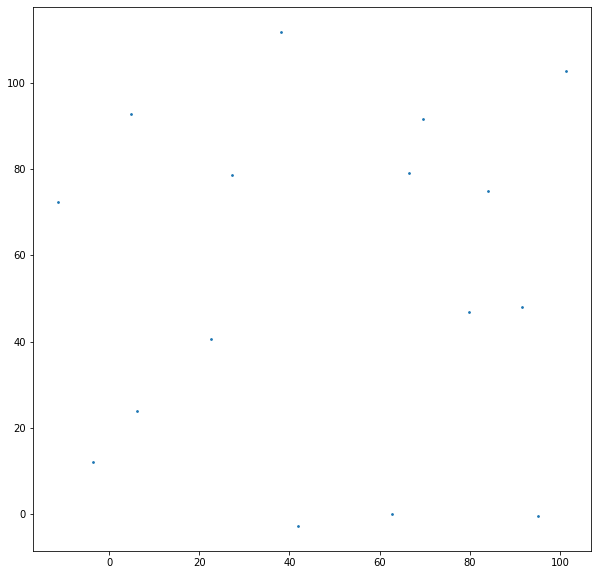

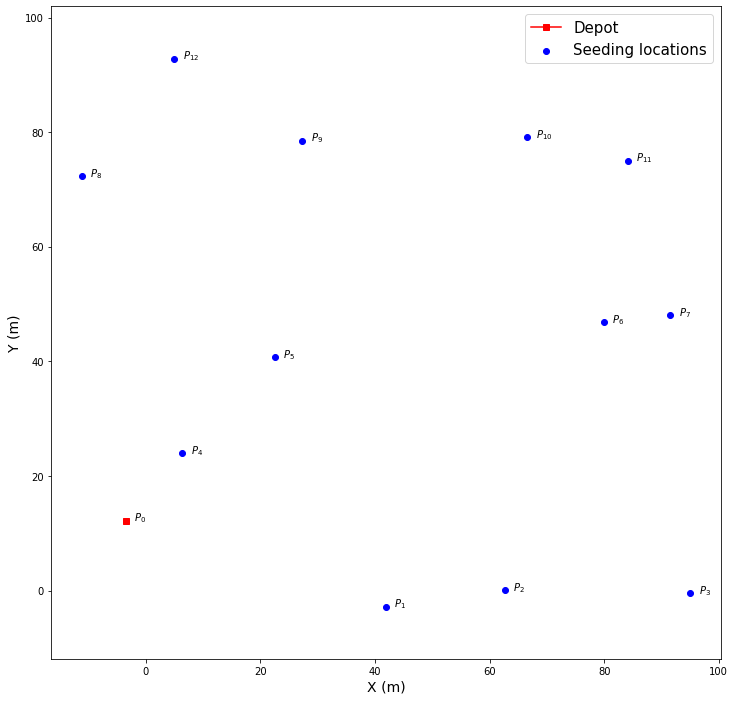

In [11]:
def init_dataset(Num_nodes,area):
    dist_bt_trees=1

    coords = generate_points_with_min_distance(n=Num_nodes, shape=(area,area), min_dist=dist_bt_trees)

    # plot
    plt.figure(figsize=(10,10))
    plt.scatter(coords[:,0], coords[:,1], s=3)
    plt.show()

    #Num_nodes=25
    N = [i for i in range(0, Num_nodes+1)]
    #print(N)
    #Number of locations

    rnd = np.random
    # loc_x = rnd.rand(len(N))*50
    # loc_y = rnd.rand(len(N))*50
    loc_x = coords[:Num_nodes+1,0]
    loc_y = coords[:Num_nodes+1,1]

    #******************************************************************************#
    fig, ax = plt.subplots(1,1,figsize=(12,12))
    plt.scatter(loc_x[1:], loc_y[1:], c='b',label='Seeding locations')
    for i in N:
        plt.annotate('$P_{%d}$' % i, (loc_x[i]+1.5, loc_y[i]))
    plt.plot(loc_x[0], loc_y[0], c='r', marker='s',label='Depot')
    plt.axis('equal')
    plt.axis('equal')
    plt.xlabel('X (m)',fontsize=14)
    plt.ylabel('Y (m)',fontsize=14)
    plt.legend(fontsize=15)
    #print(s)

    #******************************************************************************#
    A = [(i, j) for i in N for j in N if i != j]
    dist_mat= {(i, j): np.hypot(loc_x[i]-loc_x[j], loc_y[i]-loc_y[j]) for i, j in A}
    dist_mat[0,0]= 0.0
    
    return loc_x,loc_y,Num_nodes,N,dist_mat
something=init_dataset(12,100)

## Experimental Dataset Initiation

In [8]:
rnd = np.random
def init_exp_dataset(num_to_test):

    # data = pd.read_csv("/home/gyk/data/picking_list.txt",sep=',',encoding='UTF-8')
    # data = pd.read_csv("/home/gyk/data/picking_list.csv")
    #data=pd.r
    data=np.genfromtxt("/home/gyk/data/picking_list_200.txt",delimiter=',')
    #ctys = ['Boston', 'Phoenix', 'New York']
    # df = pd.DataFrame(data)
    # df.head()


    data= data[0:num_to_test+1]
    df = pd.DataFrame(data, columns=['xcord', 'ycord','zcord'])
    loc_x= np.asarray(df['xcord'])
    loc_y= np.asarray(df['ycord'])
    Num_nodes=(loc_x.shape[0])+1
    mat=pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
    dist_mat={}
    mat= np.asarray(mat)
    for i in range(0,len(mat[0])):
        for j in range(0,len(mat[1])):
            dist_mat[(i,j)]= mat[i][j]

    N= [i for i in range(0,len(mat[0]))]
    return loc_x,loc_y,Num_nodes,N,dist_mat
#print(dist_mat)


(array([ 8.02284145, 17.04767799, 14.89330673, 14.49453545, 15.54233837,
        12.16904354, 11.18013668, 11.2406044 , 12.41316319, 11.63927364,
         9.66047955,  8.82479572,  8.30545616]),
 array([  9.69976234,  -7.42568779,  -5.24734688,  -7.33663893,
         -9.87730503, -11.24702168,  -8.53960514,  -5.47746801,
         -2.8083601 ,   0.61005199,  -1.81953895,  -5.31323481,
         -8.17170238]),
 14,
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 {(0, 0): 0.0,
  (0, 1): 19.531481119771865,
  (0, 2): 16.570489703025427,
  (0, 3): 18.390893372046897,
  (0, 4): 21.14318510462401,
  (0, 5): 21.54191666667725,
  (0, 6): 18.662670415711258,
  (0, 7): 15.66848765061365,
  (0, 8): 13.357417552538658,
  (0, 9): 9.855757577906928,
  (0, 10): 11.692947796212373,
  (0, 11): 15.13042617382007,
  (0, 12): 17.97854927251341,
  (1, 0): 19.531481119771865,
  (1, 1): 0.0,
  (1, 2): 3.123418423401055,
  (1, 3): 2.5578808776597257,
  (1, 4): 2.8783175157357066,
  (1, 5): 6.201996112058053,
  (1

## Split Depots - For area size above an acre 

In [11]:
depot1= df.loc[0]
depot2=df.loc[1]
points_set = np.asarray(df)
points_d1=[]
points_d2=[]
for i in range(len(points_set)):
    dist_d1= math.hypot(points_set[i][0] - depot1[0], points_set[i][1] - depot1[1])
    dist_d2= math.hypot(points_set[i][0] - depot2[0], points_set[i][1] - depot2[1])
    if i>1 and dist_d2>dist_d1:
        points_d1.append(list(points_set[i]))
    elif i>1 and dist_d1>dist_d2:
        points_d2.append(list(points_set[i]))

points_d1,points_d2= np.asarray(points_d1),np.asarray(points_d2)
points_d1,points_d2= np.vstack((np.asarray(depot1),points_d1)),np.vstack((np.asarray(depot2),points_d2))
df1 = pd.DataFrame(data=points_d1, columns=['xcord', 'ycord','zcord'])
df2 = pd.DataFrame(data=points_d2, columns=['xcord', 'ycord','zcord'])
dist_mat1={}
dist_mat2={}
mat1=pd.DataFrame(distance_matrix(df1.values, df1.values), index=df1.index, columns=df1.index)
mat2=pd.DataFrame(distance_matrix(df2.values, df2.values), index=df2.index, columns=df2.index)
for i in range(0,len(mat1[0])):
    for j in range(0,len(mat1[1])):
        dist_mat1[(i,j)]= mat1[i][j]
for i in range(0,len(mat2[0])):
    for j in range(0,len(mat2[1])):
        dist_mat2[(i,j)]= mat2[i][j]
points_d1,points_d2= np.asarray(df1),np.asarray(df2)


#******************************************************************************#

N= [i for i in range(0,len(mat[0]))]
loc_x= np.asarray(df['xcord'])
loc_y= np.asarray(df['ycord'])
fig, ax = plt.subplots(1,1,figsize=(15,10))
plt.scatter(points_d1[:,0], points_d1[:,1], c='r')
plt.scatter(points_d2[:,0], points_d2[:,1], c='g')
for i in N:
    if i>1:
        plt.annotate('$P_{%d}$' % i, (loc_x[i]+2, loc_y[i]))
    else:
        plt.annotate('$Depot_{%d}$' % (i+1), (loc_x[i]+2, loc_y[i]))
plt.plot(depot1[0], depot1[1], c='r', marker='^',markersize=14)
plt.plot(depot2[0], depot2[1], c='g', marker='^',markersize=14)
plt.axis('equal')

NameError: name 'df' is not defined

# Algorithm
# -------------------------------------------------------------------------------------------------------------

## Functions

In [7]:
def power_P(par):
    term1= math.pow((par['frame_weight']+ par['payload_weight']),3/2)
    term2= math.sqrt(math.pow((par['grav_const']),3)/(2*par['fld_den']*par['blade_area']*par['no_rotors']))
    P= term1*term2
    return P/1000

def BatteryEnergy(t,w,alpha,beta,shi):
    term1= (alpha*w)+(beta*t)
    term2= 1-((alpha/shi*2)*t)
    return term1/term2

def random_routes (Nr,N):
    len_s= len(N)
    s=np.asarray(N)
    for i in range(1,Nr):
        s= np.insert(s,rnd.randint(len_s),0)
    s= np.append(s,0)
    return s

def random_index(s):
    i,j= rnd.randint(1,len(s)-1,2)
    if i==j:
        return random_index(s)
    return i,j

def swap (s,i,j):   
    s[i], s[j] = s[j], s[i] 
    return s

def relocate (s,i,j):
    temp = s[i]
    s=np.delete(s,i)
    s=np.insert(s, j, temp)
    return s

def two_opt(s,i,j):
    s[i:j+1] = s[i:j+1][::-1]
    return s

def adjust_rule(s,R,i,j):
    if R==1:
        return swap(s,i,j)
    elif R==2:
        return relocate (s,i,j)
    return two_opt(s,i,j)

def condition(s,s_curr,curr_temp):
    temp= -((Cost(s_curr)-Cost(s))/curr_temp)
    return np.exp(temp)

def distance(s,i,j,dist_mat):
    return dist_mat[s[i],s[j]]

def distance2(i,j,dist_mat):
    return dist_mat[i,j]

def minarrival(k):
    return min(k, key = lambda t: t[1])

def total_dist(s_curr,dist_mat):
    t_dist=0
    for ptr in range(len(s_curr)):
        try:
            i = s_curr[ptr]
            j= s_curr[ptr+1]
            dist = distance2(i,j,dist_mat)
            t_dist+=dist
        except:
            pass
    return t_dist

## Parameters 

In [8]:
init_temp=1        #Initial temperature
final_temp=0.001    #Final temperature
mu=0.9      #The amount that temperature is adjusted for every iteration
ch=600    #The number of solution adjustments for every iteration
par={'frame_weight' :3,
     'payload_weight':7,
     'grav_const':9.8,
     'fld_den':1.204,
     'blade_area':0.2,
     'no_rotors':6
}

## SA Algorithm (Heuristic-Euclidean Distance)

In [9]:
def SA(num_rts,dist_mat):
    ch=100
    N = [i for i in range(0, Num_nodes)]
    s = random_routes(num_rts,N)
    curr_temp = init_temp
    prev_dist=99999999
    track=[]
    while curr_temp > final_temp:
        curr_temp = mu*curr_temp
        for k in range(1,ch+1):
            i,j= random_index(s)
            R = rnd.randint(1,3)
            s_curr = adjust_rule(s,R,i,j)
            X= random.uniform(0,1)
            #print(X)
            #print(condition(s,s_curr,curr_temp))
            #print(Cost(s))
            cur_dist=total_dist(s_curr,dist_mat)
            #print(cond)
            if cur_dist < prev_dist:
                prev_dist=cur_dist
                track.append(cur_dist)
                s = s_curr
    print(s)
    return s

## SA Algorithm (Heuristic-Battery Efficiency)

In [10]:
def SA2(num_rts,dist_mat,seq):
    #N = [i for i in range(0, Num_nodes)]
    #print(seq)
    seq = random_routes(num_rts,seq)
    curr_temp = init_temp
    while curr_temp > final_temp:
        curr_temp = mu*curr_temp
        for k in range(1,ch+1):
            i,j= random_index(seq)
            R = rnd.randint(1,3)
            s_curr = adjust_rule(seq,R,i,j)
            #print(X)
            #print(condition(s,s_curr,curr_temp))
            #print(Cost(s))
            cond=cost(s_curr,0)
            #print(cond)
            if cond:
                #print('here')
                return s_curr
            seq=s_curr
    return False

## Cost Function

In [11]:
def cost(s,mode):
    params= {'t':0,
             'w':7,
             'y':0,
             'lamba':0.0,
             'velocity':1.0,
             'eeta':5, #Time spent at each location decending or throwing (secs)
             'Dj':0,
             'kj_cost':1,
             'K':1000,
             'const_energyden':351.648*2,
             'Q':5,
             'alpha': 0.217,
             'beta':0.185,
             'shi': 3.6*14.8*6600}#6600

    temp_list=[]
    rts=[]
    for i in s:
        if i==0:
            pass
        else:
            temp_list.append(i)
        if i==0:
            if len(temp_list):
                temp_list.insert(0,0)
                temp_list.insert(len(temp_list),0)
                rts.append(temp_list)
                temp_list=[]
    times=[]
    ctr=0
    bat_energy=[]
    bat_capacity= 170
    for every in rts:
        for ptr in range(len(every)):
            try:
                i = every[ptr]
                j= every[ptr+1]
                time_ij = 7+distance2(i,j,dist_mat)/ 1
                ctr+=time_ij
                #print(i,':',j,'----',ctr)
            except:
                pass
        #print(i,':',j,'----',ctr)
        times.append(ctr)
        bat_energy.append(BatteryEnergy(ctr,params['w'],params['alpha'],params['beta'],params['shi']))
        #print(bat_energy)
        ctr=0
        #break
    if mode ==1:
        return bat_energy[0]
    if mode ==2:
        return rts,bat_energy
    for i in bat_energy:
        if i >bat_capacity:
            #print ('--',i,'--')
            return False
    return True
    

## Calling Operations

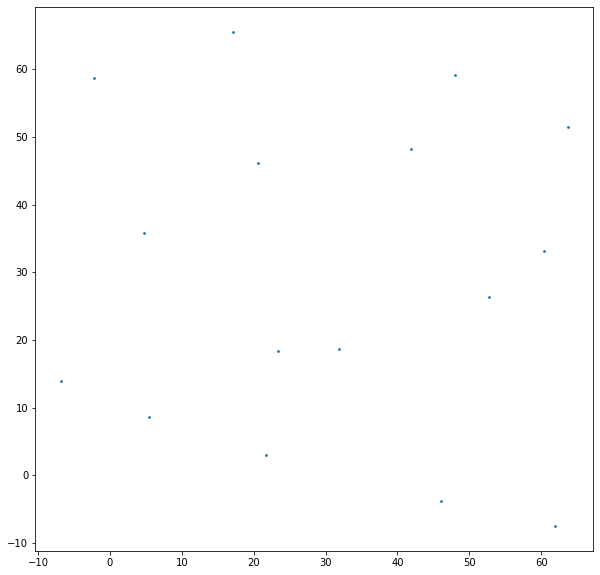

[ 0  5  3 11  1  8  9 12  4  7  6  2 10  0]
Efficiency---->65.16 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->1
time--->0.3082084655761719 secs
[ 0 12  1  5  6  3  8  2  4 11 10  9  7  0]
Efficiency---->39.41 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->2
time--->0.31606554985046387 secs
[ 0  1  4  5 11  6  9  3 10  8 12  7  2  0]
Efficiency---->66.62 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->1
time--->0.3152041435241699 secs
[ 0 12  3  7  4  6  8  1  9 10  5 11  2  0]
Efficiency---->40.62 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->2
time--->0.3240032196044922 secs
[ 0  1  3  6  5 11  7 10  2  8 12  9  4  0]
Efficiency---->54.30 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->1
time--->0.3055291175842285 secs
[ 0  8  5  4  2 12 10  3  6  7  9  1 11  0]
Efficiency---->75.35 %
Number of Nodes---->12
Area---->4553.71923828125
No.of.routes---->1
time--->0.3204536437988281 se

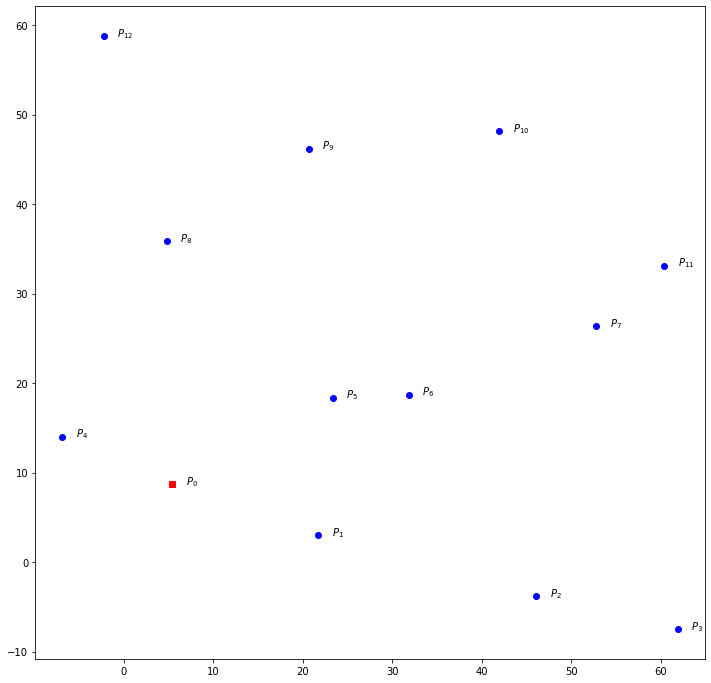

In [14]:
loc_x,loc_y,Num_nodes,N,dist_mat= init_dataset(12,60)
Num_nodes=Num_nodes+1

results=[]
#condition=True
for b in range(30):
    ch=600
    start_time= time.time()
    num_rts=1
    mode=1
    bat_limit=170
    s= SA(num_rts,dist_mat)
    min_cost=cost(s,1)
    min_rts=int(min_cost/bat_limit)
    if min_rts==0:
        min_rts=1
    #min_rts=12
    #print(min_cost,min_rts)


    for i in range(20): 
        try:
            s_temp= SA2(min_rts,dist_mat,s)
            routs,bt_energy=cost(s_temp,2)
            break
        except:
            min_rts=min_rts+1
            print(min_rts)
    endtime=time.time()
    s=s_temp

    x=0
    for i in bt_energy:
        x+= i/bat_limit

    efficiency= x*100/len(bt_energy)
    print('Efficiency---->{:.2f} %'.format(efficiency))
    print('Number of Nodes---->{}'.format(len(N)-1))

    length= abs(max(loc_x)-min(loc_x))
    brth= abs(max(loc_y)-min(loc_y))
    area=length*brth
    print('Area---->{}'.format(area))
    print('No.of.routes---->{}'.format(len(routs)))
    print('time--->{} secs'.format(endtime-start_time))
    
    results.append([50,efficiency,len(N)-1,len(routs),endtime-start_time])

#print(bt_energy)

## Efficiency

In [13]:
print(results)
x=0
for i in bt_energy:
    x+= i/bat_limit

efficiency= x*100/len(bt_energy)
print('Efficiency---->{:.2f} %'.format(efficiency))
print('Number of Nodes---->{}'.format(len(N)-1))

length= abs(max(loc_x)-min(loc_x))
brth= abs(max(loc_y)-min(loc_y))
area=length*brth
print('Area---->{}'.format(area))
print('No.of.routes---->{}'.format(len(routs)))
print('time--->{} secs'.format(endtime-start_time))

[[50, 66.63515466729179, 150, 11, 109.76976203918457], [50, 69.15207077664276, 150, 10, 90.76998567581177], [50, 74.38421608993855, 150, 10, 93.72166037559509], [50, 76.64369239450684, 150, 9, 82.19335317611694], [50, 80.92861983814528, 150, 9, 50.68746733665466], [50, 88.11307007561255, 150, 8, 61.34716033935547], [50, 69.0914523680317, 150, 10, 85.82795596122742], [50, 72.8119441915342, 150, 10, 98.74598598480225], [50, 80.68796055561033, 150, 9, 59.70914363861084], [50, 72.3032716646538, 150, 10, 107.351806640625], [50, 72.55463259344829, 150, 10, 94.06993579864502], [50, 74.73341142800828, 150, 10, 99.40764856338501], [50, 70.27690819631457, 150, 10, 100.5895025730133], [50, 65.09488582986819, 150, 11, 128.9937117099762], [50, 81.26443832110436, 150, 9, 64.02167010307312], [50, 79.41880304635585, 150, 9, 69.63756370544434], [50, 78.4952792665037, 150, 9, 55.44937038421631], [50, 72.43628213663648, 150, 10, 81.6075484752655], [50, 79.45371569920505, 150, 9, 90.11392188072205], [50, 

## Output Visualization

[0, 1, 2, 3, 0, 4, 5, 0, 8, 12, 9, 0, 6, 7, 11, 10, 0]


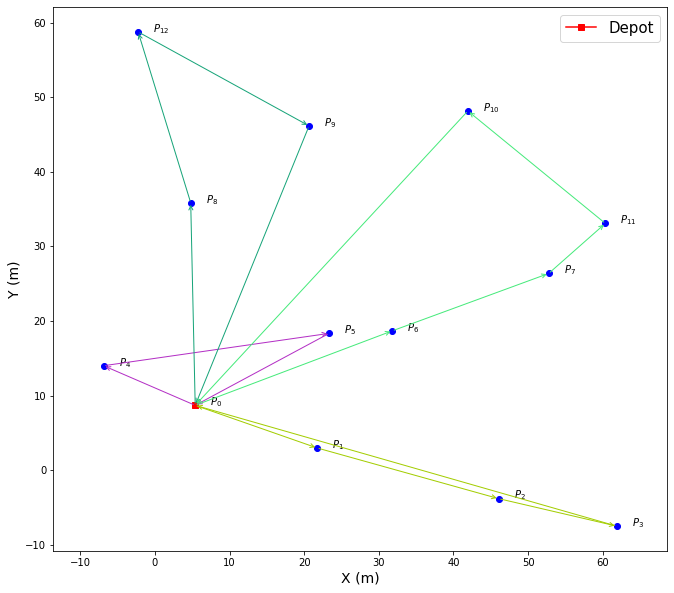

In [25]:
s= [0,1,2,3,0,4,5,0,8,12,9,0,6,7,11,10,0]
fig, ax = plt.subplots(1,1,figsize=(11,10))
# loc_x= np.asarray(df['xcord'])
# loc_y= np.asarray(df['ycord'])
plt.scatter(loc_x[1:], loc_y[1:], c='b')
for i in N:
    plt.annotate('$P_{%d}$' % i, (loc_x[i]+2, loc_y[i]))
plt.plot(loc_x[0], loc_y[0], c='r', marker='s',label='Depot')

count=0
for i in range(0,len(s)):
    if s[i]==0:
        count+=1
        r = rnd.random()
        b = rnd.random()
        g = rnd.random()
        clor=  (r, g, b)
    try:
        
        plt.annotate("",
                    xy=[loc_x[s[i+1]], loc_y[s[i+1]]], xycoords='data',
                    xytext=[loc_x[s[i]], loc_y[s[i]]], textcoords='data',
                    arrowprops=dict(arrowstyle="->",
                                    connectionstyle="arc3",color=clor))
    except:
        pass
    
plt.axis('equal')
plt.xlabel('X (m)',fontsize=14)
plt.ylabel('Y (m)',fontsize=14)
plt.legend(fontsize=15)
print(s)


In [15]:
Eff=[]
num_nod=[]
area_metre=[]
Norts=[]
times=[]
for k in results:
    np.asarray(Eff.append(k[1]))
    np.asarray(num_nod.append(k[2]))
    np.asarray(area_metre.append(k[0]))
    np.asarray(Norts.append(k[3]))
    np.asarray(times.append(k[4]))
    
df= pd.DataFrame(columns={'Efficiency','Number of Nodes','Area','No.of.routes','time'})
df['Efficiency']=Eff
df['Number of Nodes']=num_nod
df['Area']=area_metre
df['No.of.routes']=Norts
df['time']=times

In [16]:
df.to_csv("/home/gyk/data/150_50_SA.csv")

In [18]:
df

,Number of Nodes,Area,No.of.routes,Efficiency,time
0,150,50,11,66.635155,109.769762
1,150,50,10,69.152071,90.769986
2,150,50,10,74.384216,93.721660
3,150,50,9,76.643692,82.193353
4,150,50,9,80.928620,50.687467
5,150,50,8,88.113070,61.347160
6,150,50,10,69.091452,85.827956
7,150,50,10,72.811944,98.745986
8,150,50,9,80.687961,59.709144
9,150,50,10,72.303272,107.351807


## Probablity


In [ ]:

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
# fig.suptitle('Gaussian fit for left run')

axes[0].set_title('Without outlier Right - x')
axes[1].set_title('Without outlier Right - y')
axes[2].set_title('Without outlier Right - Angle')

axes[0].set_ylabel('Density of number of counts')
axes[1].set_ylabel('Density of number of counts')
axes[2].set_ylabel('Density of number of counts')

axes[0].set_xlabel('x (cm)')
axes[1].set_xlabel('y (cm)')
axes[2].set_xlabel('Theta (deg)')


sns1 = sns.distplot(Right_X, bins=5, fit=norm, kde=False, hist=True, color = 'g', ax=axes[0], fit_kws= {"label":'Gaussian fit'}, hist_kws= {"label":'Histogram'})
sns2 = sns.distplot(Right_Y, bins=5, fit=norm, kde=False, hist=True, color = 'b', ax=axes[1], fit_kws= {"label":'Gaussian fit'}, hist_kws= {"label":'Histogram'})
sns3 = sns.distplot(Right_T, bins=5, fit=norm, kde=False, hist=True, color = 'c',ax=axes[2], fit_kws= {"label":'Gaussian fit'}, hist_kws= {"label":'Histogram'})
axes[0].legend()
axes[1].legend()
axes[2].legend()
sns1.grid()
sns2.grid()
sns3.grid()
plt.savefig('Gaussian fit for right arc')
plt.show()